In [1]:
import os
import tensorflow as tf
import numpy as np
import gym
import gym_pyfr
from stable_baselines import DQN #Change for different policies
import saliency
from matplotlib import pyplot as P
import matplotlib.patches as patches

In [2]:
def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

In [3]:
model_dir = "trained_models/dqn_cnn_model.pkl"  #Change for different policies
init_file = "../../init_states/coarse/Re50_shedding.pyfrs" #change re
mesh_file = '../../meshes/cylinder_mesh_coarse.pyfrm'
baseline_file = "../../baseline_solutions/coarse/Re50_baseline.h5" #change re

env = gym.make('gym-pyfr-v0',
                mesh_file = mesh_file,
                init_file = init_file,
                baseline_file = baseline_file,
                backend = "openmp",
                discrete = True,
                n=50) # change discrete setting for different policies

model = DQN.load(model_dir, env)
obs = env.reset()

/Users/anthonycorso/Workspace/gym-pfyr/gym_pyfr/envs/plot_utils.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


In [4]:
# Construct the scalar neuron tensor.
logits = model.step_model.q_values
neuron_selector = tf.placeholder(tf.int32)
y = logits[0][1]

# Construct tensor for predictions.
prediction = tf.argmax(logits, 1)

In [5]:
gradient_saliency = saliency.GradientSaliency(model.graph, model.sess, y, model.step_model.obs_ph)

In [6]:
vanilla_mask_3d = gradient_saliency.GetMask(obs, feed_dict = {model.step_model.obs_ph: obs})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(obs, feed_dict = {model.step_model.obs_ph: obs})

In [7]:
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

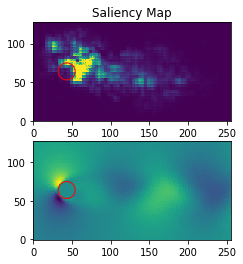

In [12]:

P.subplot(2,1,1)
P.imshow(smoothgrad_mask_grayscale, origin='lower')
P.title("Saliency Map")
circ = patches.Circle((43,64), radius = 11, edgecolor='r', facecolor='none')
P.gca().add_patch(circ)

P.subplot(2,1,2)
P.imshow(obs[:,:,2], origin='lower')
circ = patches.Circle((43,64), radius = 11, edgecolor='r', facecolor='none')
P.gca().add_patch(circ)


P.savefig("saliency.pdf")


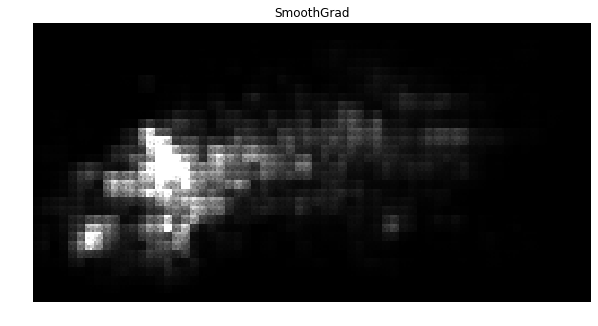

In [9]:
# Set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
# ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 1))